In [2]:
#Preamble
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
import copy
import pickle
import emcee
import corner

In [3]:
def generateEllipse(a,b,centerX,centerY, grid, opacity):
    for x in range(len(grid)):
        for y in range(len(grid[0])):
            if a > 0 and b > 0:
                if ((x-centerX)/a)*((x-centerX)/a) + ((y-centerY)/b)*((y-centerY)/b) <= 1:
                    grid[x][y] = opacity
    
    return grid

In [4]:
def transitSim(a,b,r, speed, times, tref, opacity):
    ab = a/b
    br = b/r
    
    tmin = tref - 1/(2*speed)
    tmax = tref + 1/(2*speed)
    transitTimes = [t for t in times if t >= tmin and t <= tmax]
    flux = [1 for t in times if t < tmin]
    differences = []
    for i in range(1,len(transitTimes)):
        differences.append(transitTimes[i] - transitTimes[i-1])
    
    minDiff = np.min(differences)
    intDiffs = [int(d/minDiff) for d in differences]
    length = np.sum(intDiffs)
    
    
    res = int((2*(b+r))/length)
    if res < 1:
        res = 1
    rnew = int(res*length/(2*(1+br)))
    bnew = int(br*rnew)
    anew = int(ab*bnew)
    newIntDiffs = [res*i for i in intDiffs]
    
    starGrid = np.zeros([2*rnew, 4*bnew+2*rnew+4])
    ellipseGrid = np.zeros([2*rnew, 4*bnew+2*rnew+4])
    starGrid = generateEllipse(rnew,rnew,rnew, 2*bnew+rnew, starGrid,1)
    ellipseGrid = generateEllipse(anew,bnew,rnew,3*bnew+2*rnew + 2,ellipseGrid,opacity)
    planetGrid = np.ones([2*rnew,4*bnew+2*rnew+ 4]) - ellipseGrid
    fluxGrid = np.multiply(starGrid,planetGrid)
    initialFlux = np.sum(fluxGrid)
    
    for i in newIntDiffs:
        for j in range(i):
            planetGrid = np.delete(planetGrid,0,1)
            planetGrid = np.append(planetGrid,np.ones([2*rnew,1]),1)
            
        
        fluxGrid = np.multiply(starGrid,planetGrid)
        percentFlux = np.sum(fluxGrid)/initialFlux
        flux.append(percentFlux)
        
    for t in times:
        if t > tmax:
            flux.append(1)
    
    flux.append(1)
    return flux

In [21]:
def logLikelihood(theta, times, flux, fluxErr):
    """
    Calculates the log likelihood based on the difference between the model and the data
    
    Args:
        theta (list) - parameters of the model
        times (list) - time array of the light curve
        flux (list) - array of flux data points
        fluxErr (list) - array of errors for the flux data points
    
    Returns:
        lnl (float) - log likelihood for the given theta values
    """
    xdim, ydim, velocity, tRef, opacity = theta
    fluxPredicted = transitSim(xdim, ydim,50,velocity,times, tRef,opacity)
    error = [((flux[i] - fluxPredicted[i])**2) /(2*fluxErr[i]**2) for i in range(len(flux))]
    lnl = -np.sum(error)
    return lnl

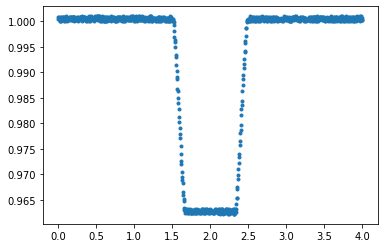

In [22]:
times = np.linspace(0,4,1000)
flux = transitSim(10,10,50,1,times,2,1)
fluxErr = 0.001*np.ones(1000)
flux = flux + np.random.random(1000)*fluxErr
fig = plt.subplot()
fig.plot(times, flux, ls = '', marker = '.')
plt.show()


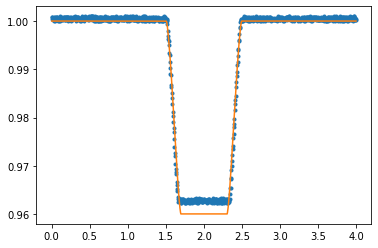

-3250.2515466444293


In [31]:
theta = [12,10,1,2,0.7]

predictedFlux = transitSim(theta[0],theta[0],50,theta[2],times,theta[3],theta[4])
fig = plt.subplot()
fig.plot(times, flux, ls = '', marker = '.')
fig.plot(times, predictedFlux)
plt.show()

print(logLikelihood(theta, times, flux, fluxErr))

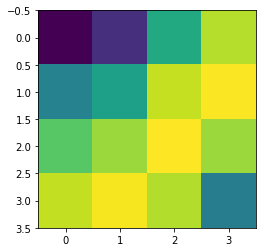

In [26]:
logProbabilities = []
for i in range(8,12):
    tempLogProbs = []
    for j in range(8,12):
        theta = [i,j,1,2,1]
        tempLogProbs.append(logLikelihood(theta, times, flux, fluxErr))
    logProbabilities.append(tempLogProbs)
    
fig = plt.subplot()
fig.imshow(logProbabilities, cmap = 'viridis')